# Poem Shapes

### Live site: https://poem-shapes.firebaseapp.com

Exploring poetic form through geometry

In [346]:
import json 
import pandas as pd
import re
import requests
import drawSvg as draw
from bs4 import BeautifulSoup
import datetime as dt
import time

In [353]:
## utils ##

colors = pd.read_csv('colors.csv')['colors'].to_list()

def remove_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

## Get poems from poets.org API

In [ ]:
def get_theme_list():
    r = requests.get("https://api.poets.org/api/taxonomy_term/themes")
    themes_raw = r.json()['data']
    return [{'id': t['attributes']['drupal_internal__tid'], 'name': t['attributes']['name']} for t in themes_raw]


def get_json_poems(json):
    poems = json['rows']
    return pd.DataFrame(poems)

def get_theme_poems(id):
    df = pd.DataFrame()
    r = requests.get("https://api.poets.org/api/poems?field_poem_themes_target_id={}&page=1".format(id))
    data = r.json()
    df = df.append(get_json_poems(data))
    df['page'] = 1
    max_page = data['pager']['total_pages']
    for i in range(2, max_page):
        r = requests.get("https://api.poets.org/api/poems?field_poem_themes_target_id={}&page={}".format(id, i))
        new = get_json_poems(r.json())
        new['page'] = i
        df = df.append(new)
    df = df.reset_index().drop(columns=['index'])
    df['theme_id'] = id
    return df

def get_all_themes(themes):
    df = pd.DataFrame()
    for t in themes:
        new_df = get_theme_poems(t['id'])
        df = df.append(new_df)
        print(t)
    return df


# save poems externally
themes_list = get_theme_list()
poems = get_all_themes(themes_list)
poems.to_json('theme_poems.json', orient='records')

## Load poems/clean data

In [354]:
with open('../data/theme_poems.json', 'r') as f:
    poems = json.load(f)
    raw_poems = pd.DataFrame(poems)

In [355]:
def clean_poems_df(df):
    df = df.loc[df.theme_id!=896] # removing audio category, thereby also removing audio only
    
    df = df.loc[~df.view_node.isnull()] # remove blanks
    df = df.loc[df.view_node!='recollections-my-christmas-tree'] # single prose piece?
    df = df.loc[~df.view_node.str.contains('node/')] # remove these two weird ones??
    
    df['author'] = [remove_html(str(x)) for x in df['field_author']]
    
    themes_agg = df[['view_node','theme_id']].groupby('view_node').aggregate(lambda x: list(x))

    df = df.drop(columns=['headers','index','page','theme_id','field_author','content'])
    
    df = df.drop_duplicates()
    
    df = df.merge(themes_agg, how = 'left', on='view_node')
 
    df['first_theme'] = [x[0] for x in df['theme_id']] # this prioritizes alphabetically :(
    
    return df
    
    
def get_theme_map():
    r = requests.get("https://api.poets.org/api/taxonomy_term/themes")
    themes_raw = r.json()['data']
    return {t['attributes']['drupal_internal__tid']: t['attributes']['name'] for t in themes_raw}


poems_df = clean_poems_df(raw_poems)

themes = get_theme_map()
# mapping colors
theme_colors = {t: colors[i] for i,t in enumerate(themes)}

Previewing poem rows...

In [356]:
poems_df.head(10)

,body,field_date_published,title,view_node,author,theme_id,first_theme
0,<p>It is rare that I<br />have to stop eating...,2018,Amuse-Bouche,/poem/amuse-bouche,Max Ritvo,"[851, 971, 1011]",851
1,<p><em>for Maria Jesus Martinez</em></p><p>Yo...,2018,Where Love Is Ground to Wheat,/poem/where-love-ground-wheat,J. Michael Martinez,"[851, 971]",851
2,<pre>The cataract whirling down the precipice...,1920,Fragment,/poem/fragment-1,John Clare,[851],851
3,<pre>If I had a million lives to live\n \tan...,1919,Humdrum,/poem/humdrum,Carl Sandburg,"[851, 856, 971]",851
4,<pre>No matter how he wrested himself silent ...,2018,Leaving,/poem/leaving-0,Allison Adelle Hedge Coke,"[851, 971, 1021, 1076]",851
5,<pre>I kissed a kiss in youth\n Upon a dead...,1922,Scintilla,/poem/scintilla,William Stanley Braithwaite,"[851, 971]",851
6,"<p><span class=""long-line"">Come find me under...",2018,The Dying Girl &amp; The Date Palm,/poem/dying-girl-date-palm,Jennifer Givhan,"[851, 971]",851
7,<pre>As due by many titles I resign\nMyself t...,2018,As due by many titles I resign (Holy Sonnet II),/poem/due-many-titles-i-resign-holy-sonnet-ii,John Donne,[851],851
8,<pre>Can’st thou conjure a vanished morn of s...,1903,Aftermath,/poem/aftermath-1,Willa Cather,"[851, 856, 901]",851
9,<pre>One morning the spirit of my lover’s unc...,2018,XI,/poem/xi,Ruben Quesada,"[851, 971, 1066]",851


## Drawing SVGs for each poem

In [357]:
def clean_poem(text):
    
    flatten = lambda l: [item for sublist in l for item in sublist]

    if 'For Carl Solomon' in text: #special case for howl-parts-i-ii
        text_arr = text.split('</span>')
        return text_arr[0].split('\n') + [remove_html(t) for t in text_arr[1:]]
    
    if '<p>' in text or '<pre>' in text or '<div>' in text:
        text = text.strip()
        
        if '</div>' in text:
            text_arr = text.split('</div>')
        else:
            text_arr = [text]
 
        for delimiter in ['<br />','<br />','\n']:
            if delimiter in text:
                text_arr = [t.split(delimiter) for t in text_arr]
                text_arr = flatten(text_arr)
                
        return [remove_html(t) for t in text_arr]
    else:
        return text.split("\n")

def draw_rect(x, y, chars, color):
    return draw.Rectangle(x*5, y, chars*5, 10, fill = color)

def fill_rect(y, width): 
    return draw.Rectangle(0, y, width, 10, fill = '#ffffff')

def get_params(arr):
    num_lines = len(arr)

    orig_lens = [len(x) for x in arr]
    max_len = max(orig_lens)
    leading = [max((len(a) - len(a.lstrip())), (a.count('\xa0'))) for a in arr]
    new_arr = [a.replace('\xa0','') for a in arr]
    lens = [len(x.strip()) for x in new_arr]
    lens = [min(210,l) for l in lens] ## REMOVING LONGER THAN 210 ???
    chars = len(''.join(new_arr))
    
    fill_width = 350
    if max_len > 70 and max_len <=140:
        fill_width = 700
    elif max_len > 140:
        fill_width = 1050
#         if max_len > 210:
#             print('exceeded at ',max_len)
    
    return num_lines, max_len, leading, lens, fill_width, chars
    

def draw_poem(text, spacing=2, color='#a6cee3', name='test2.svg'):
    #print(text)
    text_array = clean_poem(text)
    num_lines, max_len, leading, lens, fill_width, _ = get_params(text_array)
    #print(max_len)
    ht = (num_lines * (10 + spacing)) + 20
    #d = draw.Drawing(5*max_len, ht, origin=(0,-ht + 20))

    d = draw.Drawing(fill_width, ht, origin=(0,-ht + 20))
    for i, l in enumerate(lens):
        x = leading[i]
        y = i*(-10-spacing)
        d.append(fill_rect(y, fill_width))
        d.append(draw_rect(x, y, l, color))
    d.saveSvg(name)
    return d

### A few examples
Many more on site (https://poem-shapes.firebaseapp.com)

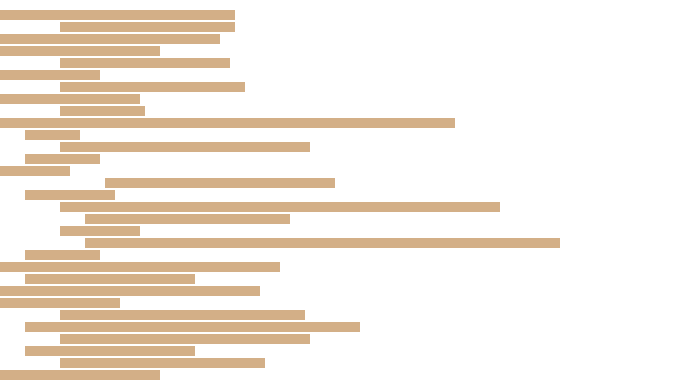

In [360]:
sample = poems_df.sample(1).iloc[0]
draw_poem(sample['body'], color=theme_colors[sample['first_theme']])


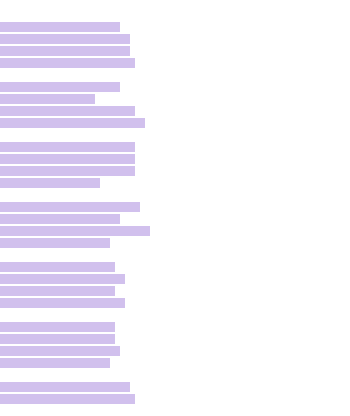

In [361]:
sample = poems_df.sample(1).iloc[0]
draw_poem(sample['body'], color=theme_colors[sample['first_theme']])


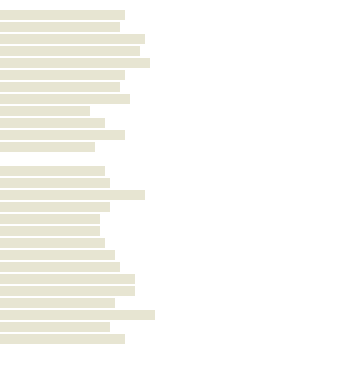

In [362]:
sample = poems_df.sample(1).iloc[0]
draw_poem(sample['body'], color=theme_colors[sample['first_theme']])


## Functions to export HTML/information for site (https://poem-shapes.firebaseapp.com)

The CSV generated goes to SheetDB, powering the API in the site.
The generated HTML are the opening poems to the index.html itself.

In [ ]:
## Draw all poems

def draw_all(df, folder):    
    for i in range(0,len(df)):
        d = df.iloc[i]
        text = d.body
        color = theme_colors[df.iloc[i].first_theme]
        file = d.view_node.replace('/poem/','') + '.svg'
        try:
            draw_poem(text, color = color, name = folder + file)
        except:
            print(d)

draw_all(poems_df, '../public/img/')

In [ ]:
# get HTML for poems or get information about poems

def get_all(data, type='info'):
        
    text = data['body'] 
    text_array = clean_poem(text)
    num_lines, max_len, _, _, fill_width, chars = get_params(text_array)
    
    if fill_width == 1050:
        fig = 'w3'
        height = round(num_lines * 8.266)
    elif fill_width == 700:
        fig = 'w2'
        height = round(num_lines * (49/6))
    else:
        fig = ''
        height = round(num_lines * (47/6)) ## to fix?

    info = {
            "short_name" : data['view_node'].replace('/poem/',''),
            "fig" : fig,
            "num_lines" : num_lines,
            "max_len" : max_len,
            "chars" : chars
     }


    if type=='info':
        return pd.Series(info)    
    
    else: 
        # return html if not returning info
        html = """
            <div class="box {fig} shuffle-item shuffle-item--visible" 
                        data-reviews="{num_lines}" data-max-len="{max_len}" data-chars="{chars}"
                        style="height: {height}px;">
            <a href="https://poets.org/poem/{short_name}" target="_blank">
                <img src = '../img/{short_name}.svg'></img></a>
            </div>
        """.format(fig=fig, num_lines=num_lines, max_len = max_len, chars = chars, height=height, short_name=info['short_name'])

        return html

In [323]:
# Save information of poems for site

def get_info(df, file):
    out_df = pd.DataFrame()
    for i in range(0,len(df)):
        try:
            out_df = out_df.append(get_all(df.iloc[i]), ignore_index=True)
        except:
            print("Exception at poem ", i)
    out_df = out_df.sample(frac=1).reset_index(drop=True) #randomize order
    out_df.to_csv(file, index=False)

get_info(poems_df, '../data/poems_info.csv')

In [337]:
# Select initial poems for index.html

df = poems_df
for i in range(0,len(df)):
    if df.iloc[i].view_node.replace('/poem/','') in  [
            'red-brocade',
            'very-old-woman',
            'learning-swim',
            'doing',
            'mixed-always',
            'beauty-1'
                ]:
        try:
            print(get_all(df.iloc[i], type='html')+ '\n')
        except:
            print('exception at poem ', i)


            <div class="box  shuffle-item shuffle-item--visible" 
                        data-reviews="25" data-max-len="43" data-chars="631"
                        style="height: 196px;">
            <a href="https://poets.org/poem/very-old-woman" target="_blank">
                <img src = '../img/very-old-woman.svg'></img></a>
            </div>
        


            <div class="box w2 shuffle-item shuffle-item--visible" 
                        data-reviews="35" data-max-len="135" data-chars="2170"
                        style="height: 286px;">
            <a href="https://poets.org/poem/beauty-1" target="_blank">
                <img src = '../img/beauty-1.svg'></img></a>
            </div>
        


            <div class="box  shuffle-item shuffle-item--visible" 
                        data-reviews="27" data-max-len="37" data-chars="594"
                        style="height: 212px;">
            <a href="https://poets.org/poem/mixed-always" target="_blank">
             